In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

In [2]:
cpu_data = pd.read_csv('/Users/MichaelKuby/Documents/Higher Education/SFU/Courses/CMPT 353 - Jupyter Notebooks/Exercise 3/sysinfo.csv', header=0)

In [3]:
cpu_data['timestamp'] = pd.to_datetime(cpu_data['timestamp'])
cpu_data

,timestamp,temperature,sys_load_1,cpu_percent,fan_rpm,cpu_freq
0,2018-05-10 00:00:34.102496,38,0.67,0.0819,693.0,1652.985500
1,2018-05-10 00:01:34.106931,38,0.59,0.0746,691.0,1751.238375
2,2018-05-10 00:02:34.111049,40,0.60,0.0564,699.0,1644.140375
3,2018-05-10 00:03:34.115387,40,0.61,0.0925,703.0,1827.442625
4,2018-05-10 00:04:34.119495,39,0.46,0.0794,694.0,1797.277125
...,...,...,...,...,...,...
2155,2018-05-11 11:55:42.894303,32,0.07,0.0125,624.0,2110.895750
2156,2018-05-11 11:56:42.897937,32,0.09,0.0125,624.0,1696.616750
2157,2018-05-11 11:57:42.901833,33,0.09,0.0136,625.0,1708.956500
2158,2018-05-11 11:58:42.905579,34,0.08,0.0150,629.0,1950.104125


In [4]:
# Apply LOESS curve smoothening technique.
filtered = lowess(cpu_data['temperature'], cpu_data['timestamp'], frac=.02)

In [143]:
kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1', 'fan_rpm']]

# What is my best guess for the 'true' intitial state?
initial_state = kalman_data.iloc[0]

# Observation covariance: what are the standard deviations for each of the variables that make up my state?
# These values were obtained by using cpu_data['column'].describe()
observation_covariance = np.diag([0.1, 0.05, 0.46, 15]) ** 2

# Transition covariance: what are the predicted standard deviations for each of the variables that make up my prediction matrix?
# These values were chosen based on the idea that our prediction is likely to have a similar
# or slightly smaller error as that compared to the observed values.
transition_covariance = np.diag([0.07, 0.05, 0.46, 15]) ** 2

"""
What are my predictions for the next value based on the current values?

temperature = 0.96 * temperature + 0.5 x cpu_percent + 0.2 * sys_load_1 - 0.001 x fan_rpm
cpu_percent = 0.1 * temperature + 0.4 x cpu_percent _ 2.3 * sys_load_1
sys_load_1 = 0.96 * sys_load_1
fan_rpm = fan_rpm
"""
transition = [[0.96, 0.5, 0.2, -0.001], [0.1 ,0.4 , 2.3, 0], [0,0, 0.96,0], [0,0,0,1]]

In [144]:
kf = KalmanFilter(
    initial_state_mean = initial_state,
    initial_state_covariance = observation_covariance,
    observation_covariance = observation_covariance,
    transition_covariance = transition_covariance,
    transition_matrices = transition
)

pred_state, state_cov = kf.smooth(kalman_data)

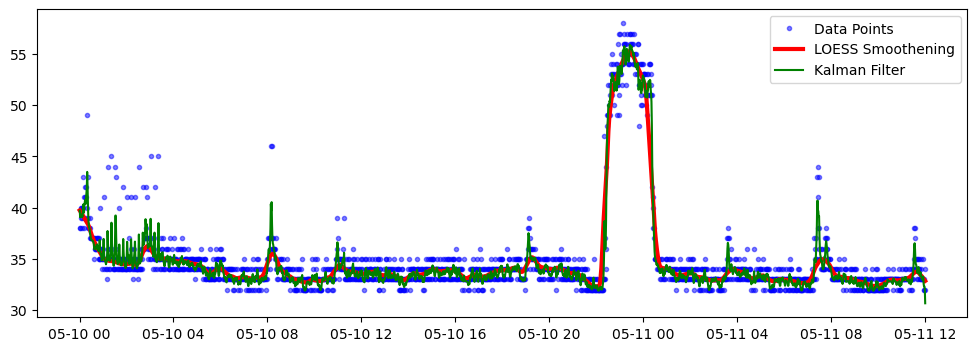

In [160]:
# Plot the results
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5);
plt.plot(cpu_data['timestamp'], filtered[:, 1], 'r-', linewidth=3)
plt.plot(cpu_data['timestamp'], pred_state[:, 0], 'g-')
plt.legend(['Data Points', 'LOESS Smoothening', 'Kalman Filter'])
plt.show()